# Data Modelling and Evaluation

## Objectives

* Fulfil project objective - use the data insights gained from the DataVisualisation notebook to train the ML model to make predictions on whether leaves are infected or not

## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation

## Outputs

* model pkl file
* model evaluation pkl file
* augmented image embeddings 
* graph images displaying model loss and accuracy data

## Additional Comments

* No additional comments




---

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
sns.set_style("white")
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image 

---

# Change working directory

Access the current directory with os.getcwd()

In [2]:
cwd = os.getcwd()

Set new directory

In [3]:
os.chdir('/workspace/Mildew-Detection')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Mildew-Detection'

# Set Input Directories


In [16]:
my_data_dir = '/workspace/Mildew-Detection/inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set Output Directory

In [6]:
# If new version needed, just change version variable
version = 'v1'

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

# Set Label Names

In [13]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Number of Images in Sets 

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




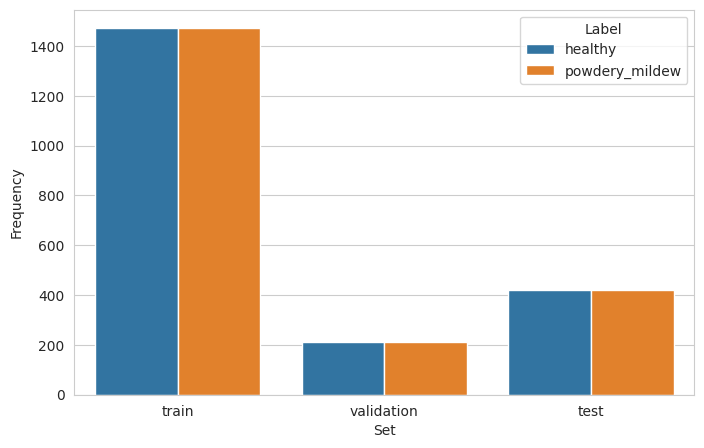

In [8]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Image Augmentation

Image augmentation using tensorflow

In [181]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Augmentation for Training
augmented_image_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

In [182]:
validation_image_data = ImageDataGenerator(rescale=1./255)

Apply augmentation to sets 

In [183]:
train_set = augmented_image_data.flow_from_directory(
    directory=train_path,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [184]:
validation_set = validation_image_data.flow_from_directory(
    directory=val_path,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=10,
    class_mode='binary',
    shuffle=True  
)
validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [185]:
test_set = validation_image_data.flow_from_directory(
    directory=test_path,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=20,
    class_mode='binary',
    shuffle=False  # No shuffling for test set to maintain order
)

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented train image examples

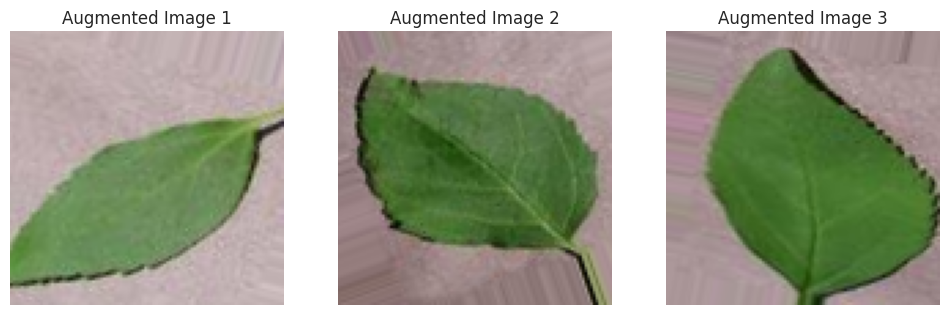

In [187]:

plt.figure(figsize=(12, 4)) 

for i in range(3):
    img_batch, label_batch = next(train_set)  
    img = img_batch[0] 


    img = img.astype('float32') 
    if np.max(img) > 1:
        img /= 255.0  

    # Plot images
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')


plt.show()

Plot augmented images for validation and test sets

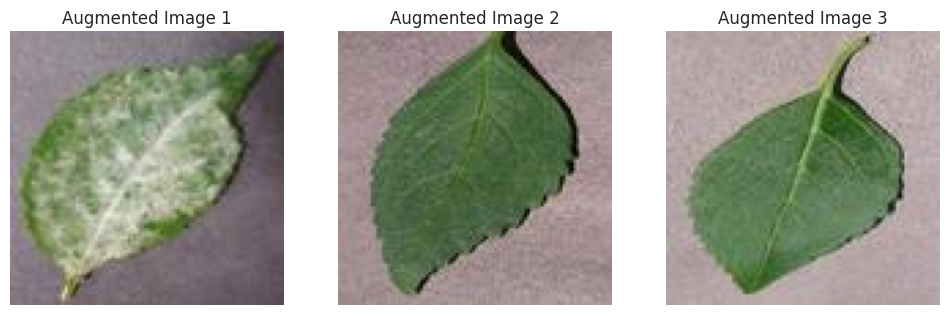

In [188]:
plt.figure(figsize=(12, 4)) 

for i in range(3):
    img_batch, label_batch = next(validation_set)  
    img = img_batch[0] 


    img = img.astype('float32') 
    if np.max(img) > 1:
        img /= 255.0  

    # Plot images
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

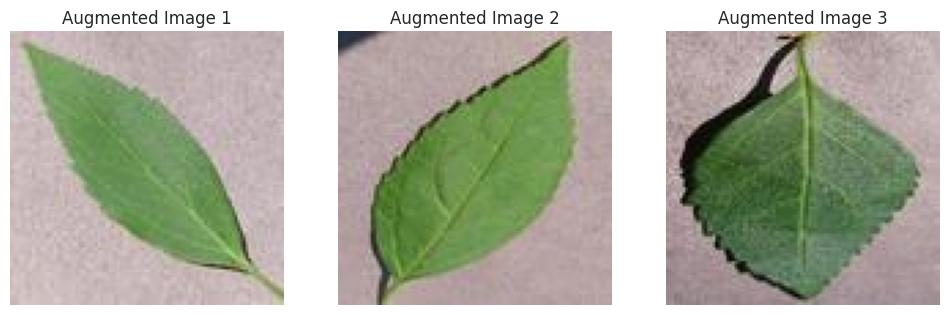

In [189]:
plt.figure(figsize=(12, 4)) 

for i in range(3):
    img_batch, label_batch = next(test_set)  
    img = img_batch[0] 


    img = img.astype('float32') 
    if np.max(img) > 1:
        img /= 255.0  

    # Plot images
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

Save indices to output folder

In [190]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Building the Model

In [191]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    
    #first Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    #output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    #model compilation
    model.compile(
        #slightly reduced learning rate for stability
        optimizer=Adam(learning_rate=0.0001),  
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#create the model
model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 21, 21, 128)     

# Conclusions and Next Steps

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.